# Comparing return level wind speeds for different GPD fitting methods

To make full use of the scenarios generated in TCRM, it is preferred to use a Generalised Pareto Distribution (GPD) to fit the extremes of the distribution of simulated wind speeds. This utilises the peaks-over-threshold (POT) approach, rather than the block maxima (BM) approach used for the Generalised Extreme Value (GEV) distribution.

The fit of the GPD is highly sensitive to the selected threshold in POT methods. Too low a threshold and the fit is biased towards the bulk distribution at lower values. Too high a threshold and there are too few data points to provide a stable fit. Further to this, we want to select a threshold that results in a GPD with a negative shape parameter so that the resulting return levels are bounded. 

Here, we have precalculated the parameters for a GPD from the simulated TC wind speeds at a large number of locations across Australia. We used the iterative threshold selection method described by Sanabria and Cechet (2007), and a maximum likelihood estimation method, implemented in the `scipy.stats` package, using an arbitrary threshold (in our case, the 99.5th percentile of the simulated wind speeds at the site). We compare the return levels using these two methods, with a view to implementing one or the other in the TCRM code.

In [1]:
%matplotlib notebook

import os
import sys
from os.path import join as pjoin

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

sns.set_context('notebook')
sns.set_style('darkgrid')

We start with loading the data. This includes the return levels calculated using the iterative threshold selection and the percentile threshold selection, and the distribution parameters for each method. You can use the [tcrmextremes.py](https://github.com/wcarthur/extremes/blob/python/tcrmextremes.py) script to build these data files. This relies on a completed simulation of TCRM for the region 

In [2]:
inputPath = "N:/georisk/HaRIA_B_Wind/data/derived/tc/tcha/process"
iterative_rl_file = pjoin(inputPath, "iterative_rl.csv")
fitted_rl_file = pjoin(inputPath, "fitted_rl.csv")
parameter_file = pjoin(inputPath, "parameters.csv")
names = ['locId', 'locName', '1', '2', '5', '10', '20', '50',
         '100', '200', '500', '1000', '2000', '5000', '10000']
usecols = ['locId', '1', '2', '5', '10', '20', '50', '100',
           '200', '500', '1000', '2000', '5000', '10000']

it = pd.read_csv(iterative_rl_file, names=names, index_col='locId',
                 usecols=usecols, header=0)
ft = pd.read_csv(fitted_rl_file, names=names, index_col='locId',
                 usecols=usecols, header=0)

paramnames = ['locId', 'locName', 'it_scale', 'it_shape', 'it_thresh', 'it_rate',
              'gpd_rate', 'gpd_shape', 'gpd_thresh', 'gpd_scale']
usecols = ['locId', 'locName', 'it_scale', 'it_shape', 'it_thresh', 'it_rate',
           'gpd_rate', 'gpd_shape', 'gpd_thresh', 'gpd_scale']
params = pd.read_csv(parameter_file, names=paramnames, index_col='locId', header=0)

We need to filter the data, to remove those records with an undefined shape parameter, a threshold of zero (which indicates a location with very few data points), and positive return level values for all return periods. This ensures the statistics we inspect are not influenced by questionable data. The replacement of invalid values is performed in-place.

In [3]:
idx = params.where((params['it_shape'] !=0.0 ) & (params['gpd_shape'] != 0.0) &\
                   (params['gpd_thresh'] != 0.0) & (ft['1'] > 0.0) & (it['1'] > 0.0))
flag = idx['it_shape'].isnull()
it.loc[flag] = np.nan
ft.loc[flag] = np.nan

In [4]:
diff = it.rsub(ft, axis=0)
diff

,1,2,5,10,20,50,100,200,500,1000,2000,5000,10000
locId,,,,,,,,,,,,,
10606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10594,-3.48,-2.37,-1.26,-0.65,-0.22,0.10,0.18,0.14,-0.07,-0.34,-0.69,-1.26,-1.75
10589,-1.52,-0.72,0.05,0.45,0.68,0.81,0.78,0.64,0.34,0.03,-0.34,-0.92,-1.42
10588,1.23,0.95,0.63,0.42,0.21,-0.03,-0.18,-0.33,-0.51,-0.61,-0.72,-0.83,-0.92
10607,-0.80,-0.54,-0.28,-0.13,-0.02,0.05,0.07,0.05,-0.02,-0.11,-0.23,-0.42,-0.59
10590,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10591,6.39,5.25,3.93,3.06,2.30,1.43,0.86,0.38,-0.16,-0.50,-0.79,-1.09,-1.27
10595,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10599,-4.60,-3.28,-1.90,-1.11,-0.50,0.03,0.25,0.32,0.23,0.03,-0.27,-0.81,-1.30


In [5]:
diff.mean()

1       -2.845531
2       -1.868031
5       -0.854281
10      -0.273625
20       0.164656
50       0.552094
100      0.716562
200      0.783813
500      0.741906
1000     0.622719
2000     0.437875
5000     0.106313
10000   -0.201469
dtype: float64

In [6]:
diff.std()

1        6.606138
2        5.050852
5        3.413970
10       2.466662
20       1.768758
50       1.272107
100      1.226020
200      1.370558
500      1.679964
1000     1.949278
2000     2.241752
5000     2.673848
10000    3.044106
dtype: float64

Plot these data in a simple box plot to view the results.

<IPython.core.display.Javascript object>


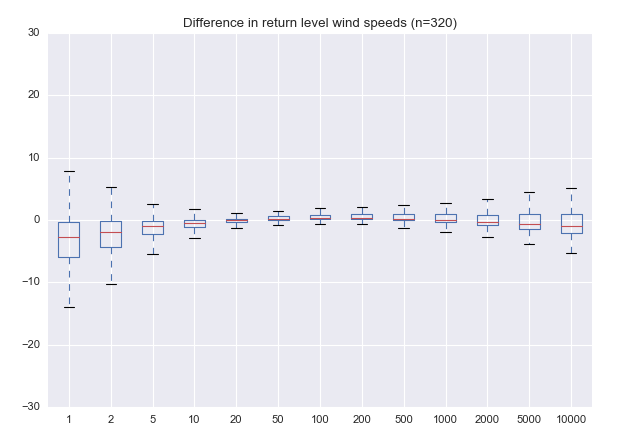

In [12]:
diff.plot.box(title="Difference in return level wind speeds (n={0})".format(diff["1"].notnull().sum()))

So, with 320 valid sites, the mean difference between the two methods is at most 2.8 m/s. For the return periods that we are interested in for extreme events (> 50 years), the mean difference between the two methods is no more than 1 m/s. 

In terms of computing return levels quickly, the percentile threshold selection method is far superior. Given the computational efficiency, and the minimal differences in return levels (especially at long return periods), the percentile threshold selection method is being implemented into TCRM.